# Sentiment Analysis of Twitter Text

In today’s world, Twitter provides people with a way to publicly express their thoughts on any given subject in a concise, condensed format. This allows us to use tweets as a way to predict users’ thoughts or feelings on a certain subject.

Since the 2016 U.S. election, the influence of social media on society has become more and more concerning. Fake news, hate speech, polarization, and echo chambers attract growing scholarships to pay attention to the discussions in the online space. Understanding the sentimental content on social media is crucial to further analysis

In this project, we are going to compare and contrast two models on the performance of classifying a tweet based on sentiments.

## Load data and pre-processing

In [1]:
# import your libraries here
import pandas as pd
import nltk
import re
import numpy as np
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /Users/zhenguo/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
df_tweet = pd.read_csv('data/Tweets.csv')

In [3]:
df_tweet

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative
...,...,...,...,...
27476,4eac33d1c0,wish we could come see u on Denver husband l...,d lost,negative
27477,4f4c4fc327,I`ve wondered about rake to. The client has ...,", don`t force",negative
27478,f67aae2310,Yay good for both of you. Enjoy the break - y...,Yay good for both of you.,positive
27479,ed167662a5,But it was worth it ****.,But it was worth it ****.,positive


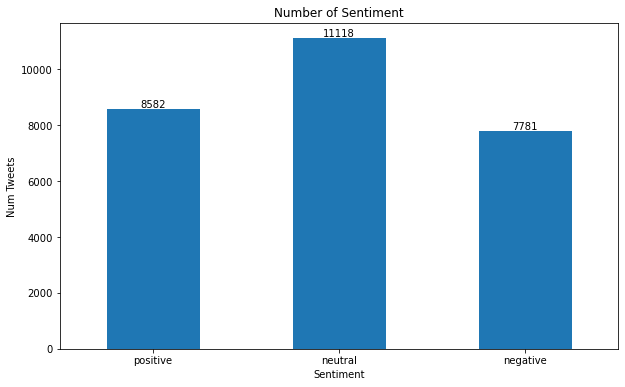

In [13]:
import matplotlib.pyplot as plt

#calculate sum of points for each team
df_groups = df_tweet.groupby(['sentiment'])['sentiment'].count().reindex(['positive', 'neutral','negative'])

#create bar plot with custom aesthetics
ax = df_groups.plot(kind='bar', title='Number of Sentiment',
               ylabel='Num Tweets', xlabel='Sentiment', figsize=(10, 6))

ax.bar_label(ax.containers[0])

#rotate x-axis ticks vertically
plt.xticks(rotation=0)
plt.savefig('sentiment_dis.png', bbox_inches = 'tight')

In [6]:
count = 0
for i in df_tweet['text'].values:
    if type(i) != str:
        count += 1
print(count)

1


## BERTweet
https://huggingface.co/docs/transformers/model_doc/bertweet

In [7]:
from transformers import AutoModel, AutoTokenizer

/opt/anaconda3/envs/class/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2022-12-06 15:31:57.306293: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
bertweet = AutoModel.from_pretrained("vinai/bertweet-base")
tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-base", use_fast=False)

### Data Cleaning
- remove tweets classified as 'neutral' so that we can perform binary classification
- remove non-string tweets
    - possibly just map these to strings?

In [6]:
# https://stackoverflow.com/questions/39275533/select-row-from-a-dataframe-based-on-the-type-of-the-objecti-e-str
# df[df['A'].apply(lambda x: isinstance(x, str))]
df_tweet_bert = df_tweet[df_tweet['text'].apply(lambda x: isinstance(x, str))].reset_index()
df_tweet_bert = df_tweet_bert[df_tweet_bert['sentiment'] != 'neutral'].reset_index()
#df_tweet_bert = df_tweet.loc[type(df_tweet['text']) == str]

In [7]:
df_tweet_bert

,level_0,index,textID,text,selected_text,sentiment
0,1,1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
1,2,2,088c60f138,my boss is bullying me...,bullying me,negative
2,3,3,9642c003ef,what interview! leave me alone,leave me alone,negative
3,4,4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative
4,6,6,6e0c6d75b1,2am feedings for the baby are fun when he is a...,fun,positive
...,...,...,...,...,...,...
16358,27474,27475,b78ec00df5,enjoy ur night,enjoy,positive
16359,27475,27476,4eac33d1c0,wish we could come see u on Denver husband l...,d lost,negative
16360,27476,27477,4f4c4fc327,I`ve wondered about rake to. The client has ...,", don`t force",negative
16361,27477,27478,f67aae2310,Yay good for both of you. Enjoy the break - y...,Yay good for both of you.,positive


In [9]:
from sentence_transformers import SentenceTransformer

roberta_model = SentenceTransformer('paraphrase-distilroberta-base-v1');

def normalize_encode_tweet(tweet):
    norm = tokenizer.normalizeTweet(tweet)
    encoded = roberta_model.encode(norm)
    return encoded

In [51]:
from tqdm import tqdm

# show progress
tqdm.pandas()

# https://www.geeksforgeeks.org/create-a-new-column-in-pandas-dataframe-based-on-the-existing-columns/
df_tweet_bert['embedding'] =  df_tweet_bert.progress_apply(lambda row: normalize_encode_tweet(row.text), axis=1)

100%|██████████| 16363/16363 [12:04<00:00, 22.57it/s]


In [53]:
# df_tweet_bert.to_csv('tweet_roberta_embeddings.csv', index=False)

In [3]:
df_tweet_bert = pd.read_csv('tweet_roberta_embeddings.csv')

In [4]:
df_tweet_bert.drop(df_tweet_bert.columns[[0, 1, 2]], axis=1,inplace=True)

In [13]:
df_tweet_bert.head()

,textID,text,selected_text,sentiment,embedding
0,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,[ 9.30877551e-02 4.43676770e-01 1.10505581e-...
1,088c60f138,my boss is bullying me...,bullying me,negative,[-2.20891997e-01 -2.87244469e-02 1.46015704e-...
2,9642c003ef,what interview! leave me alone,leave me alone,negative,[ 1.11802444e-02 -4.25624251e-01 1.02491967e-...
3,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,[ 1.77452222e-01 2.84410834e-01 5.99784851e-...
4,6e0c6d75b1,2am feedings for the baby are fun when he is a...,fun,positive,[-1.04325861e-01 2.68305153e-01 -1.53165251e-...


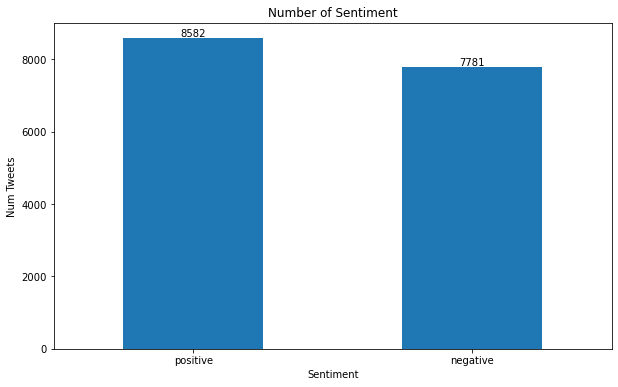

In [6]:
import matplotlib.pyplot as plt

#calculate sum of points for each team
df_groups = df_tweet_bert.groupby(['sentiment'])['sentiment'].count().reindex(['positive','negative'])

#create bar plot with custom aesthetics
ax = df_groups.plot(kind='bar', title='Number of Sentiment',
               ylabel='Num Tweets', xlabel='Sentiment', figsize=(10, 6))

ax.bar_label(ax.containers[0])

#rotate x-axis ticks vertically
plt.xticks(rotation=0)
plt.savefig('sentiment_dis2.png', bbox_inches = 'tight')

In [14]:
import statsmodels.formula.api

from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [15]:
# test train split
# X = df_tweet_bert['embedding']
# when reading BERT from csv
X = df_tweet_bert['embedding'].apply(lambda s: ([float(x.strip(" \n")) for x in s.strip("[]").split()])).values.tolist()
y = df_tweet_bert['sentiment'].map({'negative': 0, 'positive': 1}).values.tolist()

# train + test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=1)
# re-split train to have training, validation, testing sets
# https://datascience.stackexchange.com/questions/15135/train-test-validation-set-splitting-in-sklearn
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.25, random_state=1) # 0.2/0.8 = 0.25

# train = 60%, val = 20%, test = 20% of original data
# TODO: need higher proportion of training data?

## Train Neural Net

### Data
Reformat X and y so that they can be passed into neural net

In [16]:
# training set
X_train_nn = np.asarray(X_train)
y_train_nn = y_train
y_train_nn = np.asarray([np.array(y) for y in y_train_nn])

# use validation set in training
X_val_nn = np.asarray(X_val)
y_val_nn = y_val
y_val_nn = np.asarray([np.array(y) for y in y_val_nn])
validation_set = (X_val_nn, y_val_nn)

# testing set
X_test_nn = np.asarray(X_test)
y_test_nn = y_test
y_test_nn = np.asarray([np.array(y) for y in y_test_nn])

### Training and Evaluation

Hyperparameters experimented with:
- Activation function for hidden layer
- Number of nodes in the hidden layer

In [38]:
# Importing utility functions from Keras
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Embedding

In [57]:
# sklearn evaluation metrics
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

In [174]:
def train_evaluate_nn(net):
    """
    trains the given neural net on our training data
    prints out model summary and metrics
    """
    # fit training data and validaiton data
    net.fit(X_train_nn, 
            y_train_nn, 
            epochs = 20, 
            batch_size = 10,
            validation_data = validation_set,
            verbose = 0)
    # predict x_test values
    y_pred_temp = net.predict(X_test_nn)
    # convert from probabilities to 0/1
    y_pred_net = [1 if y > 0.5 else 0 for y in y_pred_temp]
    
    # print metrics and net description
    net_accuracy = accuracy_score(y_test_nn, y_pred_net)
    net_precision = precision_score(y_test_nn, y_pred_net)
    net_recall = recall_score(y_test_nn, y_pred_net)
    net_f1 = f1_score(y_test_nn, y_pred_net)
    
    print(net.summary())    
    print(f'Neural Net Accuracy:  {net_accuracy}')
    print(f'Neural Net Precision: {net_precision}')
    print(f'Neural Net Recall:    {net_recall}')
    print(f'Neural Net F1 Score:  {net_f1}')

In [175]:
# 1 hidden layer w/ 128 nodes and relu activation
nn1 = Sequential(name='1_hidden_layer_with_128_nodes_sigmoid_relu_activation')
nn1.add(Dense(256, input_shape=(768,), activation='sigmoid', name='input'))
nn1.add(Dense(128, activation='relu', name='hidden'))
nn1.add(Dense(1, activation='sigmoid', name='output'))
nn1.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])

train_evaluate_nn(nn1)

103/103 [==============================] - 0s 874us/step
Model: "1_hidden_layer_with_128_nodes_sigmoid_relu_activation"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (Dense)               (None, 256)               196864    
                                                                 
 hidden (Dense)              (None, 128)               32896     
                                                                 
 output (Dense)              (None, 1)                 129       
                                                                 
Total params: 229,889
Trainable params: 229,889
Non-trainable params: 0
_________________________________________________________________
None
Neural Net Accuracy:  0.8900091659028414
Neural Net Precision: 0.9193846153846154
Neural Net Recall:    0.8670922809053976
Neural Net F1 Score:  0.8924731182795699


In [176]:
# 1 hidden layer w/ 128 nodes and sigmoid activation
nn2 = Sequential(name='1_hidden_layer_with_128_nodes_sigmoid_sigmoid_activation')
nn2.add(Dense(256, input_shape=(768,), activation='sigmoid', name='input'))
nn2.add(Dense(128, activation='sigmoid', name='hidden'))
nn2.add(Dense(1, activation='sigmoid', name='output'))
nn2.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])

train_evaluate_nn(nn2)

103/103 [==============================] - 0s 858us/step
Model: "1_hidden_layer_with_128_nodes_sigmoid_sigmoid_activation"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (Dense)               (None, 256)               196864    
                                                                 
 hidden (Dense)              (None, 128)               32896     
                                                                 
 output (Dense)              (None, 1)                 129       
                                                                 
Total params: 229,889
Trainable params: 229,889
Non-trainable params: 0
_________________________________________________________________
None
Neural Net Accuracy:  0.8927589367552704
Neural Net Precision: 0.9127557160048135
Neural Net Recall:    0.8804410911201392
Neural Net F1 Score:  0.8963072378138849


In [177]:
# 1 hidden layer w/ 128 nodes and softmax activation
nn3 = Sequential(name='1_hidden_layer_with_128_nodes_sigmoid_softmax_activation')
nn3.add(Dense(256, input_shape=(768,), activation='sigmoid', name='input'))
nn3.add(Dense(128, activation='softmax', name='hidden'))
nn3.add(Dense(1, activation='sigmoid', name='output'))
nn3.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])

train_evaluate_nn(nn3)

103/103 [==============================] - 0s 949us/step
Model: "1_hidden_layer_with_128_nodes_sigmoid_softmax_activation"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (Dense)               (None, 256)               196864    
                                                                 
 hidden (Dense)              (None, 128)               32896     
                                                                 
 output (Dense)              (None, 1)                 129       
                                                                 
Total params: 229,889
Trainable params: 229,889
Non-trainable params: 0
_________________________________________________________________
None
Neural Net Accuracy:  0.5264283531927895
Neural Net Precision: 0.5264283531927895
Neural Net Recall:    1.0
Neural Net F1 Score:  0.689751801441153


In [178]:
# 1 hidden layer w/ 64 nodes and relu activation
nn4 = Sequential(name='1_hidden_layer_with_64_nodes_sigmoid_relu_activation')
nn4.add(Dense(256, input_shape=(768,), activation='sigmoid', name='input'))
nn4.add(Dense(64, activation='relu', name='hidden'))
nn4.add(Dense(1, activation='sigmoid', name='output'))
nn4.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])

train_evaluate_nn(nn4)

103/103 [==============================] - 0s 872us/step
Model: "1_hidden_layer_with_64_nodes_sigmoid_relu_activation"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (Dense)               (None, 256)               196864    
                                                                 
 hidden (Dense)              (None, 64)                16448     
                                                                 
 output (Dense)              (None, 1)                 65        
                                                                 
Total params: 213,377
Trainable params: 213,377
Non-trainable params: 0
_________________________________________________________________
None
Neural Net Accuracy:  0.8921478765658417
Neural Net Precision: 0.9024676850763808
Neural Net Recall:    0.8914683691236216
Neural Net F1 Score:  0.8969343065693431


In [179]:
# 1 hidden layer w/ 64 nodes and sigmoid activation
nn5 = Sequential(name='1_hidden_layer_with_64_nodes_sigmoid_sigmoid_activation')
nn5.add(Dense(256, input_shape=(768,), activation='sigmoid', name='input'))
nn5.add(Dense(64, activation='sigmoid', name='hidden'))
nn5.add(Dense(1, activation='sigmoid', name='output'))
nn5.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])

train_evaluate_nn(nn5)

103/103 [==============================] - 0s 867us/step
Model: "1_hidden_layer_with_64_nodes_sigmoid_sigmoid_activation"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (Dense)               (None, 256)               196864    
                                                                 
 hidden (Dense)              (None, 64)                16448     
                                                                 
 output (Dense)              (None, 1)                 65        
                                                                 
Total params: 213,377
Trainable params: 213,377
Non-trainable params: 0
_________________________________________________________________
None
Neural Net Accuracy:  0.8854262144821264
Neural Net Precision: 0.8842645381984037
Neural Net Recall:    0.9001741149158444
Neural Net F1 Score:  0.8921484037963762


In [180]:
# 1 hidden layer w/ 64 nodes and softmax activation
nn6 = Sequential(name='1_hidden_layer_with_64_nodes_sigmoid_softmax_activation')
nn6.add(Dense(256, input_shape=(768,), activation='sigmoid', name='input'))
nn6.add(Dense(64, activation='softmax', name='hidden'))
nn6.add(Dense(1, activation='sigmoid', name='output'))
nn6.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])

train_evaluate_nn(nn6)

103/103 [==============================] - 0s 877us/step
Model: "1_hidden_layer_with_64_nodes_sigmoid_softmax_activation"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (Dense)               (None, 256)               196864    
                                                                 
 hidden (Dense)              (None, 64)                16448     
                                                                 
 output (Dense)              (None, 1)                 65        
                                                                 
Total params: 213,377
Trainable params: 213,377
Non-trainable params: 0
_________________________________________________________________
None
Neural Net Accuracy:  0.8918423464711274
Neural Net Precision: 0.9275452841973766
Neural Net Recall:    0.8618688334300638
Neural Net F1 Score:  0.8935018050541516


## Logistic Regression

In [73]:
from sklearn.linear_model import LogisticRegression

### Training and Evaluation
Increased `max_iter` for all models as needed to avoid convergence warnings

Hyperparameters:
- `solver`: the algorithm to use in the optimization process
- `penalty`: norm of the penalty term - not all penalties can be used with all solvers

In [77]:
def train_evaluate_logistic_regression(model, description):
    # train model
    trained_model = model.fit(X_train, y_train)
    # predict
    y_pred = trained_model.predict(X_test)
    
    # metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(description)
    print(f'Logistic Regression Accuracy:  {accuracy}')
    print(f'Logistic Regression Precision: {precision}')
    print(f'Logistic Regression Recall:    {recall}')
    print(f'Logistic Regression F1 Score:  {f1}')

In [161]:
# lbfgs, l2
log_reg1 = LogisticRegression(max_iter=500,
                              penalty='l2',
                              solver='lbfgs',
                              random_state=1)

train_evaluate_logistic_regression(log_reg1, 'lbfgs, l2')

lbfgs, l2
Logistic Regression Accuracy:  0.8875649251451267
Logistic Regression Precision: 0.9016004742145821
Logistic Regression Recall:    0.8827626233313988
Logistic Regression F1 Score:  0.8920821114369502


In [162]:
# lbgfs, none
log_reg2 = LogisticRegression(max_iter=500,
                              penalty='none',
                              solver='lbfgs',
                              random_state=1)

train_evaluate_logistic_regression(log_reg2, 'lbfgs, none')

lbfgs, none
Logistic Regression Accuracy:  0.8802322028719829
Logistic Regression Precision: 0.8944872554831061
Logistic Regression Recall:    0.8757980266976204
Logistic Regression F1 Score:  0.8850439882697947


In [163]:
# newton-cg, l2
log_reg3 = LogisticRegression(max_iter=500,
                              penalty='l2',
                              solver='newton-cg',
                              random_state=1)

train_evaluate_logistic_regression(log_reg3, 'newton-cg, l2')

newton-cg, l2
Logistic Regression Accuracy:  0.8878704552398411
Logistic Regression Precision: 0.902135231316726
Logistic Regression Recall:    0.8827626233313988
Logistic Regression F1 Score:  0.8923437958345557


In [164]:
# newton-cg, none
log_reg4 = LogisticRegression(max_iter=500,
                              penalty='none',
                              solver='newton-cg',
                              random_state=1)

train_evaluate_logistic_regression(log_reg4, 'newton-cg, none')

newton-cg, none
Logistic Regression Accuracy:  0.8802322028719829
Logistic Regression Precision: 0.8944872554831061
Logistic Regression Recall:    0.8757980266976204
Logistic Regression F1 Score:  0.8850439882697947


In [165]:
# liblinear, l2
log_reg5 = LogisticRegression(max_iter=500,
                              penalty='l2',
                              solver='liblinear',
                              random_state=1)

train_evaluate_logistic_regression(log_reg5, 'liblinear, l2')

liblinear, l2
Logistic Regression Accuracy:  0.8875649251451267
Logistic Regression Precision: 0.9016004742145821
Logistic Regression Recall:    0.8827626233313988
Logistic Regression F1 Score:  0.8920821114369502


In [166]:
# liblinear, l1
log_reg6 = LogisticRegression(max_iter=500,
                              penalty='l1',
                              solver='liblinear',
                              random_state=1)

train_evaluate_logistic_regression(log_reg6, 'liblinear, l1')

liblinear, l1
Logistic Regression Accuracy:  0.8881759853345554
Logistic Regression Precision: 0.9031491384432561
Logistic Regression Recall:    0.8821822402785838
Logistic Regression F1 Score:  0.8925425719318849


In [168]:
# sag, l2
log_reg7 = LogisticRegression(max_iter=500,
                              penalty='l2',
                              solver='sag',
                              random_state=1)

train_evaluate_logistic_regression(log_reg7, 'sag, l2')

sag, l2
Logistic Regression Accuracy:  0.8875649251451267
Logistic Regression Precision: 0.9016004742145821
Logistic Regression Recall:    0.8827626233313988
Logistic Regression F1 Score:  0.8920821114369502


In [169]:
# sag, none
log_reg8 = LogisticRegression(max_iter=500,
                              penalty='none',
                              solver='sag',
                              random_state=1)

train_evaluate_logistic_regression(log_reg8, 'sag, none')

sag, none
Logistic Regression Accuracy:  0.8805377329666972
Logistic Regression Precision: 0.895017793594306
Logistic Regression Recall:    0.8757980266976204
Logistic Regression F1 Score:  0.8853036080962159


In [170]:
# saga, l2
log_reg9 = LogisticRegression(max_iter=500,
                              penalty='l2',
                              solver='saga',
                              random_state=1)

train_evaluate_logistic_regression(log_reg9, 'saga, l2')

saga, l2
Logistic Regression Accuracy:  0.8875649251451267
Logistic Regression Precision: 0.9016004742145821
Logistic Regression Recall:    0.8827626233313988
Logistic Regression F1 Score:  0.8920821114369502


In [171]:
# saga, l1
log_reg10 = LogisticRegression(max_iter=500,
                               penalty='l1',
                               solver='saga',
                               random_state=1)

train_evaluate_logistic_regression(log_reg10, 'saga, l1')

saga, l1
Logistic Regression Accuracy:  0.8881759853345554
Logistic Regression Precision: 0.9031491384432561
Logistic Regression Recall:    0.8821822402785838
Logistic Regression F1 Score:  0.8925425719318849


In [187]:
# saga, none
log_reg11 = LogisticRegression(max_iter=800,
                               penalty='none',
                               solver='saga',
                               random_state=1)

train_evaluate_logistic_regression(log_reg11, 'saga, none')

saga, none
Logistic Regression Accuracy:  0.8799266727772685
Logistic Regression Precision: 0.8944246737841044
Logistic Regression Recall:    0.8752176436448056
Logistic Regression F1 Score:  0.8847169257846876


In [188]:
# saga, elasticnet
log_reg12 = LogisticRegression(max_iter=500,
                               penalty='elasticnet',
                               solver='saga',
                               random_state=1)

train_evaluate_logistic_regression(log_reg12, 'saga, elasticnet')

ValueError: l1_ratio must be between 0 and 1; got (l1_ratio=None)

# Citations

Download the lexicon from http://www.cs.uic.edu/~liub/FBS/opinion-lexicon-English.rar and extract it into `data/positive-words.txt` and `data/negative-words.txt`.

The following pre-processing steps are inspired from https://towardsdatascience.com/text-normalization-for-natural-language-processing-nlp-70a314bfa646.

We also pre-processed data so that it begins with < s> tokens (and ends with < /s> tokens). Inspired from answer: https://stackoverflow.com/questions/37605710/tokenize-a-paragraph-into-sentence-and-then-into-words-in-nltk

normalize text to regular expression
code from https://gist.github.com/yamanahlawat/4443c6e9e65e74829dbb6b47dd81764a

- https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
- 